In [1]:
'''import packages'''
import pandas as pd
import numpy as np
from numpy import inf
import matplotlib.pyplot as plt

In [2]:
'''improt dataset and demand'''
large_data = pd.read_excel(r"C:\Users\allen\OneDrive\桌面\大規模最佳化\程式\Data.xlsx", sheet_name="Large data")
demand_large = pd.read_excel(r"C:\Users\allen\OneDrive\桌面\大規模最佳化\程式\Data.xlsx", sheet_name="Copy of Demand 1")

In [3]:
# 此處更改資料集 large & small
'''clean data'''
distance_matrix = large_data.drop(columns=['Distance matrix'])
distance_matrix = np.array(distance_matrix) # convert pandas to numpy
distance_matrix[distance_matrix==0]=np.inf # convert 0 to inf


'''clean demand'''
demand = demand_large.drop(columns=['Node'])
demand = np.array(demand).flatten()

In [4]:
import random as rn
import numpy as np
from numpy.random import choice as np_choice

class AntColony(object):

    def __init__(self, demand, n_ants, n_best, n_cycles, decay, alpha=1, beta=1):
        """
        Args:
            distances (2D numpy.array): Square matrix of distances. Diagonal is assumed to be np.inf.
            n_ants (int): Number of ants running per iteration
            n_best (int): Number of best ants who deposit pheromone
            n_cycles (int): Number of cycles
            decay (float): Rate it which pheromone decays. The pheromone value is multiplied by decay, so 0.95 will lead to decay, 0.5 to much faster decay.
            alpha (int or float): exponenet on pheromone, higher alpha gives pheromone more weight. Default=1
            beta (int or float): exponent on distance, higher beta give distance more weight. Default=1
        Example:
            ant_colony = AntColony(german_distances, 100, 20, 2000, 0.95, alpha=1, beta=2)          
        """
        self.demand  = demand
        self.pheromone = np.ones(self.demand.shape) / len(self.demand)
        self.all_inds = range(len(demand))
        self.n_ants = n_ants
        self.n_best = n_best
        self.n_cycles = n_cycles
        self.decay = decay
        self.alpha = alpha
        self.beta = beta
        
        '''set truck and drones specs'''
        self.drone_payload = 100
        self.drone_distance = 50
        self.truck_payload = 2800
        self.truck_distance = 500

    def run(self):
        heaviest_weight = None
        all_time_heaviest_weight = ("placeholder", 0)
        total_weight = []
        
        # 執行 n 次 cycles times
        for i in range(self.n_cycles):
            all_paths = self.gen_all_paths() # 產生每隻螞蟻走的路徑
             
            self.spread_pheronome(all_paths, self.n_best, heaviest_weight = heaviest_weight)
            heaviest_weight = max(all_paths, key=lambda x: x[1])
            print (heaviest_weight)
            if heaviest_weight[1] > all_time_heaviest_weight[1]:
                all_time_heaviest_weight = heaviest_weight           
            self.pheromone = self.pheromone * self.decay
            
            total_weight.append(heaviest_weight[1])

        return all_time_heaviest_weight, total_weight, all_paths

    def gen_all_paths(self):
        '''產生每隻螞蟻的路徑'''
        all_paths = []
        start = 0
        for i in range(self.n_ants):
            path = self.gen_path(start) # 產生每隻螞蟻走的路徑
            total_demand, total_distance = self.gen_path_dist(path, start)
            all_paths.append((path, total_demand, total_distance)) # 計算每隻螞蟻路徑的 total distance
        
        return all_paths
            
    def spread_pheronome(self, all_paths, n_best, heaviest_weight):
        '''走過的路徑增加 pheronmone'''
        
        sorted_paths = sorted(all_paths, key=lambda x: x[1], reverse=True)
        # 設定只有前 n 隻表現最佳的螞蟻需要紀錄
        for path, demand, dist in sorted_paths[:n_best]:
            for move in path:
                self.pheromone[move] += np.log10(self.demand[move])
                
    def gen_path(self, start):
        '''一隻螞蟻完成一趟 cycle 的 path'''
        path = []
        visited = set()
        truck_distance = self.truck_distance
        truck_payload = self.truck_payload
        prev = start
        truck_payload -= self.demand[start] # 扣除一開始原點的 demand weight
        visited.add(start)
        path.append(start)
        
        for i in range(len(self.demand) - 1):
            move = self.pick_move(self.pheromone, self.demand, visited)
            # 確認車子的重量
            if truck_payload >= self.demand[move]:
                if truck_distance >= distance_matrix[(prev, move)] + distance_matrix[(move, start)]:
                    truck_payload -= self.demand[move]
                    truck_distance -= distance_matrix[(prev, move)]
                    path.append(move)
                    prev = move
                    visited.add(move)
                    
            else:
                break

        path.append(start) # going back to where we started

        return path
    

    def gen_path_dist(self, path, start):
        '''計算每隻螞蟻路徑的 total distance'''
        total_demand = 0
        total_dist = 0
        # calculate demand
        for ele in path:
            total_demand += self.demand[ele]
        total_demand -= self.demand[start]
        # calculate distance
        for i in range(1,len(path)-1):
            total_dist += distance_matrix[(path[i-1],path[i])]

        return total_demand, total_dist



    def pick_move(self, pheromone, demand, visited):
        '''計算 probability 選擇 step '''
        pheromone = np.copy(pheromone)
        pheromone[list(visited)] = 0
        rho = pheromone ** self.alpha * (( demand / np.sum(demand)) ** self.beta)
        norm_rho = rho / rho.sum()
        move = np_choice(self.all_inds, 1, p=norm_rho)[0]

        return move

In [17]:
ant_colony = AntColony(demand, n_ants = 5, n_best = 1, n_cycles = 800, decay = 0.95, alpha=0.2, beta=1)
heaviest_weight, total_weight, all_paths = ant_colony.run()
print ("path: {}".format(heaviest_weight))

([0, 21, 39, 27, 17, 7, 3, 10, 36, 9, 34, 19, 23, 28, 38, 44, 15, 0], 2770.75, 211.60000000000002)
([0, 9, 35, 32, 14, 36, 38, 39, 20, 44, 15, 19, 6, 46, 23, 24, 40, 42, 34, 0], 2761.75, 225.39999999999998)
([0, 16, 3, 34, 32, 45, 12, 38, 6, 44, 7, 40, 15, 20, 17, 39, 22, 49, 0], 2799.25, 168.0)
([0, 9, 6, 23, 44, 15, 32, 46, 43, 27, 7, 22, 1, 38, 21, 16, 0], 2793.25, 212.2)
([0, 6, 7, 39, 12, 46, 26, 19, 23, 15, 27, 40, 41, 3, 14, 22, 38, 0], 2769.5, 168.8)
([0, 12, 4, 3, 27, 17, 32, 38, 23, 34, 39, 7, 10, 35, 21, 46, 0], 2791.5, 247.7)
([0, 20, 30, 21, 24, 46, 42, 34, 17, 47, 35, 27, 22, 19, 9, 33, 11, 39, 0], 2756.25, 282.90000000000003)
([0, 14, 39, 24, 21, 40, 1, 30, 19, 16, 46, 12, 6, 4, 32, 42, 35, 0], 2765.0, 247.5)
([0, 10, 30, 15, 17, 3, 24, 48, 29, 28, 32, 21, 49, 22, 33, 34, 0], 2785.5, 201.79999999999995)
([0, 45, 32, 38, 49, 3, 24, 7, 11, 48, 15, 30, 34, 6, 43, 10, 16, 0], 2712.75, 157.2)
([0, 22, 23, 32, 20, 46, 7, 30, 24, 47, 36, 3, 19, 41, 43, 10, 0], 2767.0, 155.5)
([

In [19]:
heaviest_weight[0]

[0, 12, 32, 19, 16, 29, 13, 35, 1, 30, 46, 42, 43, 47, 7, 10, 0]

In [21]:
d = 0
for i in heaviest_weight[0]:
    d += demand[i]
print(d-demand[0])

2800.0


Text(0.5, 1.0, 'Large Dataset')

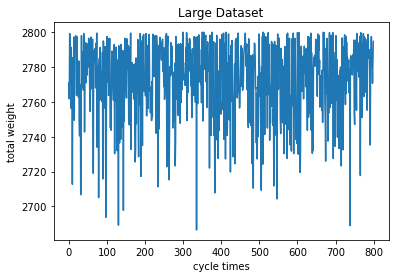

In [18]:
plt.plot(total_weight)
plt.xlabel("cycle times")
plt.ylabel("total weight")
plt.title("Large Dataset")
#plt.text(x=500, y=2788, s = "alpha=2 ; beta=0.5")